In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.feature_selection import SelectKBest, SelectFromModel, RFECV
from sklearn.model_selection import train_test_split, ShuffleSplit, GridSearchCV
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, LabelBinarizer, LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix

In [1741]:
dataset = sns.load_dataset('titanic')

In [1742]:
print('Shape: ', dataset.shape)
dataset.head()

Shape:  (891, 15)


,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


In [1743]:
for feature in dataset.columns:
    if feature not in ['age', 'fare']:
        dataset[feature] = dataset[feature].astype('category')

In [1744]:
y = dataset['survived']
X = dataset.drop('survived', axis=1)

In [1745]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=0
                                                    )

In [1746]:
numerical_features = make_column_selector(dtype_exclude='category')
categorical_features  = make_column_selector(dtype_include='category')

In [1747]:
numerical_pipeline = make_pipeline(KNNImputer(),
                                   StandardScaler()
                                   )

categorical_pipeline = make_pipeline(SimpleImputer(strategy='most_frequent'),
                                     OneHotEncoder(handle_unknown='ignore')
                                     )

In [1748]:
preprocessor = make_column_transformer((numerical_pipeline, numerical_features),
                                       (categorical_pipeline, categorical_features)
                                       )

In [1749]:
feature_selector = RFECV(SGDClassifier(random_state=0),
                         step=1,
                         min_features_to_select=7,
                         cv=5
                         )

In [1750]:
model = make_pipeline(preprocessor,
                      feature_selector,
                      KNeighborsClassifier()
                      )

In [1751]:
parameters = {'columntransformer__pipeline-1__knnimputer__weights': ['uniform', 'distance'],
              'columntransformer__pipeline-1__knnimputer__n_neighbors': np.arange(1, 6),
              'kneighborsclassifier__weights': ['uniform', 'distance'],
              'kneighborsclassifier__n_neighbors': np.arange(1, 6),
              'kneighborsclassifier__metric' : ['euclidean', 'manhattan', 'chebyshev', 'minkowski']
              }

In [1752]:
cross_val_generator = ShuffleSplit(test_size=0.2,
                                   random_state=0)

In [1753]:
grid = GridSearchCV(estimator=model,
                    param_grid=parameters,
                    cv=cross_val_generator,
                    verbose=1
                    )

In [1754]:
grid.fit(X_train, y_train)

Fitting 10 folds for each of 400 candidates, totalling 4000 fits


GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=0, test_size=0.2, train_size=None),
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('pipeline-1',
                                                                         Pipeline(steps=[('knnimputer',
                                                                                          KNNImputer()),
                                                                                         ('standardscaler',
                                                                                          StandardScaler())]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7fca865d99a0>),
                                                                        ('pipe...
             param_grid={'columntransformer__pipeline-1__knnimputer__n_neighbors': array([1,

In [1755]:
grid.best_params_

{'columntransformer__pipeline-1__knnimputer__n_neighbors': 1,
 'columntransformer__pipeline-1__knnimputer__weights': 'uniform',
 'kneighborsclassifier__metric': 'euclidean',
 'kneighborsclassifier__n_neighbors': 3,
 'kneighborsclassifier__weights': 'uniform'}

In [1756]:
grid.best_score_

1.0

In [1757]:
scores = pd.DataFrame(grid.cv_results_)
scores

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_columntransformer__pipeline-1__knnimputer__n_neighbors,param_columntransformer__pipeline-1__knnimputer__weights,param_kneighborsclassifier__metric,param_kneighborsclassifier__n_neighbors,param_kneighborsclassifier__weights,params,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.369916,0.118839,0.012735,0.005124,1,uniform,euclidean,1,uniform,{'columntransformer__pipeline-1__knnimputer__n...,...,1.0,1.000000,0.993007,1.0,1.0,1.000000,1.0,0.999301,0.002098,138
1,0.280697,0.015524,0.008063,0.001089,1,uniform,euclidean,1,distance,{'columntransformer__pipeline-1__knnimputer__n...,...,1.0,1.000000,0.993007,1.0,1.0,1.000000,1.0,0.999301,0.002098,138
2,0.319870,0.064053,0.010755,0.002245,1,uniform,euclidean,2,uniform,{'columntransformer__pipeline-1__knnimputer__n...,...,1.0,0.993007,0.993007,1.0,1.0,1.000000,1.0,0.998601,0.002797,211
3,0.274372,0.011749,0.007384,0.000488,1,uniform,euclidean,2,distance,{'columntransformer__pipeline-1__knnimputer__n...,...,1.0,1.000000,0.993007,1.0,1.0,1.000000,1.0,0.999301,0.002098,138
4,0.361255,0.111599,0.012926,0.004489,1,uniform,euclidean,3,uniform,{'columntransformer__pipeline-1__knnimputer__n...,...,1.0,1.000000,1.000000,1.0,1.0,1.000000,1.0,1.000000,0.000000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,0.569663,0.014629,0.013873,0.002197,5,distance,minkowski,3,distance,{'columntransformer__pipeline-1__knnimputer__n...,...,1.0,1.000000,1.000000,1.0,1.0,1.000000,1.0,1.000000,0.000000,1
396,0.571592,0.025612,0.017983,0.001159,5,distance,minkowski,4,uniform,{'columntransformer__pipeline-1__knnimputer__n...,...,1.0,1.000000,1.000000,1.0,1.0,1.000000,1.0,1.000000,0.000000,1
397,0.559826,0.017683,0.015962,0.002247,5,distance,minkowski,4,distance,{'columntransformer__pipeline-1__knnimputer__n...,...,1.0,1.000000,1.000000,1.0,1.0,1.000000,1.0,1.000000,0.000000,1
398,0.586394,0.025670,0.019337,0.001774,5,distance,minkowski,5,uniform,{'columntransformer__pipeline-1__knnimputer__n...,...,1.0,1.000000,1.000000,1.0,1.0,0.993007,1.0,0.998601,0.002797,211


In [1758]:
grid.score(X_test, y_test)

1.0

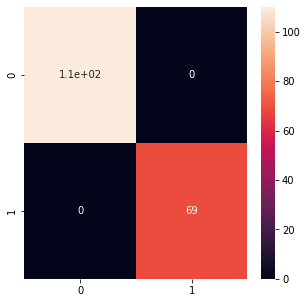

In [1759]:
plt.figure(figsize=(5, 5))
sns.heatmap(confusion_matrix(y_test, grid.best_estimator_.predict(X_test)), annot=True)
plt.show()